In [1]:
!nvidia-smi

Thu Aug  7 13:28:18 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   53C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os

# Define your base project directory on Google Drive
PROJECT_DRIVE_PATH = '/content/drive/MyDrive/Colab_Projects/CropWeedDetection_Project'

# Create the main project directory if it doesn't exist
os.makedirs(PROJECT_DRIVE_PATH, exist_ok=True)
print(f"Main project directory on Google Drive ensured: {PROJECT_DRIVE_PATH}")

# Define the output directory for models, plots, etc.
OUTPUT_DIR = os.path.join(PROJECT_DRIVE_PATH, 'outputs')
os.makedirs(OUTPUT_DIR, exist_ok=True)
print(f"Outputs will be saved to: {OUTPUT_DIR}")

# --- CRITICAL: THESE ARE THE CORRECT PATHS BASED ON YOUR SCREENSHOT ---
# Your image and label files are DIRECTLY inside 'crop_weed_data' folder.
# So, both IMAGES_DIR and LABELS_DIR will point to this common folder.
global IMAGES_DIR, LABELS_DIR # Make these variables accessible globally
DATA_ROOT_FOLDER_ON_DRIVE = os.path.join(PROJECT_DRIVE_PATH, 'crop_weed_data')
IMAGES_DIR = DATA_ROOT_FOLDER_ON_DRIVE
LABELS_DIR = DATA_ROOT_FOLDER_ON_DRIVE # Labels are in the same folder as images

print(f"Image files will be accessed from: {IMAGES_DIR}")
print(f"Label files will be accessed from: {LABELS_DIR}")

Main project directory on Google Drive ensured: /content/drive/MyDrive/Colab_Projects/CropWeedDetection_Project
Outputs will be saved to: /content/drive/MyDrive/Colab_Projects/CropWeedDetection_Project/outputs
Image files will be accessed from: /content/drive/MyDrive/Colab_Projects/CropWeedDetection_Project/crop_weed_data
Label files will be accessed from: /content/drive/MyDrive/Colab_Projects/CropWeedDetection_Project/crop_weed_data


--- Installing/Checking Libraries ---
Libraries installed/checked.

--- Performing Data Exploration and Visualization ---


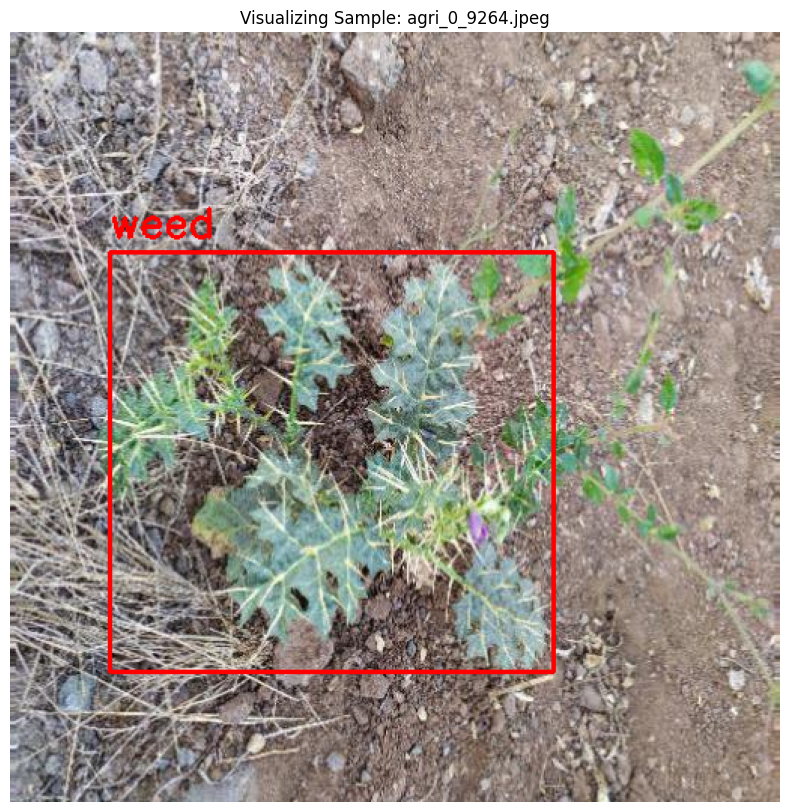

Displayed image: agri_0_9264.jpeg
Found 1 objects in this image.


In [4]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random # For choosing a random image
from sklearn.model_selection import train_test_split # Needed for splitting later

# Install libraries. Colab often has these pre-installed, but it's safe to run.
print("--- Installing/Checking Libraries ---")
!pip install opencv-python matplotlib numpy scikit-learn
print("Libraries installed/checked.")

print("\n--- Performing Data Exploration and Visualization ---")

# Now that IMAGES_DIR and LABELS_DIR are globally set (in Code Cell 3), this part should work.
# We also need to filter for images vs. text files within the common data folder.
if not os.path.exists(IMAGES_DIR) or not os.path.isdir(IMAGES_DIR) or len(os.listdir(IMAGES_DIR)) == 0:
    print(f"CRITICAL ERROR: Data directory '{IMAGES_DIR}' not found or is empty.")
    print("Please ensure your 'crop_weed_data' folder with images and labels is manually uploaded to:")
    print(f"  {PROJECT_DRIVE_PATH}/")
    print("And that Code Cell 3 set IMAGES_DIR correctly.")
else:
    all_files_in_data_folder = os.listdir(IMAGES_DIR) # IMAGES_DIR and LABELS_DIR are the same folder

    image_files = [f for f in all_files_in_data_folder if f.lower().endswith(('.jpeg', '.jpg', '.png'))]
    label_files = [f for f in all_files_in_data_folder if f.lower().endswith('.txt')]

    if not image_files:
        print(f"No image files found in {IMAGES_DIR}. Data folder might be empty or contain wrong file types.")
    elif not label_files:
        print(f"No label files found in {LABELS_DIR}. Data folder might be empty or missing labels.")
    else:
        # Pick a random image to display
        sample_image_name = random.choice(image_files)
        image_path = os.path.join(IMAGES_DIR, sample_image_name)

        # Load the image
        img = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert from BGR to RGB for Matplotlib
        h, w, _ = img.shape # Get image dimensions (height, width)

        # Load the corresponding YOLO label file
        label_file_name = os.path.splitext(sample_image_name)[0] + '.txt'
        label_path = os.path.join(LABELS_DIR, label_file_name) # LABELS_DIR is same as IMAGES_DIR

        boxes = []
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f:
                    parts = list(map(float, line.strip().split()))
                    class_id = int(parts[0])
                    x_center, y_center, bbox_width, bbox_height = parts[1:]

                    # Convert YOLO normalized coordinates to pixel coordinates
                    x_min = int((x_center - bbox_width / 2) * w)
                    y_min = int((y_center - bbox_height / 2) * h)
                    x_max = int((x_center + bbox_width / 2) * w)
                    y_max = int((y_center + bbox_height / 2) * h)

                    boxes.append([class_id, x_min, y_min, x_max, y_max])
        else:
            print(f"Warning: Label file not found for {sample_image_name} at {label_path}. No bounding boxes will be drawn.")

        # Define class names and colors based on the classes.txt file (from your initial info)
        CLASS_NAMES = {0: 'crop', 1: 'weed'} # Confirmed from classes.txt [cite: 229-231]
        COLORS = {0: (0, 255, 0), 1: (255, 0, 0)} # Green for Crop, Red for Weed

        for class_id, x_min, y_min, x_max, y_max in boxes:
            color = COLORS.get(class_id, (255, 255, 255)) # Default to white if class_id is unknown
            label_text = CLASS_NAMES.get(class_id, f'Class {class_id}') # Get class name or default

            cv2.rectangle(img_rgb, (x_min, y_min), (x_max, y_max), color, 2) # Draw rectangle
            cv2.putText(img_rgb, label_text, (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2) # Add text

        # Display the image with matplotlib
        plt.figure(figsize=(12, 10))
        plt.imshow(img_rgb)
        plt.title(f"Visualizing Sample: {sample_image_name}")
        plt.axis('off') # Hide axes
        plt.show()

        print(f"Displayed image: {sample_image_name}")
        print(f"Found {len(boxes)} objects in this image.")

In [7]:
import os
from sklearn.model_selection import train_test_split

print("--- Performing Data Splitting ---")

# IMAGES_DIR and LABELS_DIR are globally set, pointing to the same folder (crop_weed_data)
# We need to list all image and label files from this common directory.
if not 'IMAGES_DIR' in globals() or not os.path.exists(IMAGES_DIR) or len(os.listdir(IMAGES_DIR)) == 0:
    print("ERROR: IMAGES_DIR not correctly set or data not found. Cannot split data.")
else:
    # Get all files in the data folder
    all_files_in_data_folder = os.listdir(IMAGES_DIR)

    # Filter for image files and label files
    # We use sorted() to ensure consistent order for zipping pairs
    all_image_basenames = sorted([os.path.splitext(f)[0] for f in all_files_in_data_folder if f.lower().endswith(('.jpeg', '.jpg', '.png'))])
    all_label_basenames = sorted([os.path.splitext(f)[0] for f in all_files_in_data_folder if f.lower().endswith('.txt')])

    # Find common basenames to ensure we only pair images that have corresponding labels
    common_basenames = sorted(list(set(all_image_basenames) & set(all_label_basenames)))

    if not common_basenames:
        print("ERROR: No common image-label pairs found. Cannot split data.")
    else:
        # Construct full paths for valid pairs
        final_valid_image_paths = []
        final_valid_label_paths = []

        for basename in common_basenames:
            img_found = False
            current_img_path = None
            current_label_path = os.path.join(LABELS_DIR, basename + '.txt')

            for ext in ['.jpeg', '.jpg', '.png']:
                temp_img_path = os.path.join(IMAGES_DIR, basename + ext)
                if os.path.exists(temp_img_path):
                    current_img_path = temp_img_path
                    img_found = True
                    break

            if img_found and os.path.exists(current_label_path):
                final_valid_image_paths.append(current_img_path)
                final_valid_label_paths.append(current_label_path)

        print(f"Total valid image-label pairs identified: {len(final_valid_image_paths)}")

        if len(final_valid_image_paths) == 0:
            print("No valid image-label pairs found after detailed checks. Cannot split data.")
        else:
            dataset_pairs = list(zip(final_valid_image_paths, final_valid_label_paths))

            train_data, temp_data = train_test_split(dataset_pairs, test_size=0.2, random_state=42)
            val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

            print(f"\nDataset Split (80/10/10):")
            print(f"Training samples: {len(train_data)}")
            print(f"Validation samples: {len(val_data)}")
            print(f"Test samples: {len(test_data)}")
            print("--- Data Splitting Complete ---")

--- Performing Data Splitting ---
Total valid image-label pairs identified: 1300

Dataset Split (80/10/10):
Training samples: 1040
Validation samples: 130
Test samples: 130
--- Data Splitting Complete ---


In [10]:
print("--- Installing Ultralytics YOLOv8 ---")
!pip install ultralytics
print("Ultralytics YOLOv8 installed.")

import ultralytics
ultralytics.checks()

Ultralytics 8.3.175 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 43.1/112.6 GB disk)


In [9]:
import os

print("\n--- Step 2: Creating YOLO Dataset Configuration (data.yaml) ---")

# The paths to your images and labels, relative to where data.yaml will be saved.
# We will save data.yaml in PROJECT_DRIVE_PATH.
# Your image and label files are DIRECTLY in PROJECT_DRIVE_PATH/crop_weed_data/
# So, the path relative to PROJECT_DRIVE_PATH for the data is 'crop_weed_data/'

relative_data_path = 'crop_weed_data/'

yaml_content = f"""
# YOLOv8 Dataset Configuration
train: {relative_data_path} # Path to training images relative to this yaml
val: {relative_data_path}   # Path to validation images relative to this yaml
# test: {relative_data_path} # Optional: if you had a separate test set folder here

nc: 2  # Number of classes: crop, weed [cite: 229-231]
names: ['crop', 'weed'] # Class names in order of their IDs (0, 1) [cite: 229-231]
"""

# Save data.yaml to your project directory on Google Drive
data_yaml_path = os.path.join(PROJECT_DRIVE_PATH, 'data.yaml')
with open(data_yaml_path, 'w') as f:
    f.write(yaml_content)

print(f"YOLO data.yaml created at: {data_yaml_path}")
print("\n--- data.yaml Content ---")
print(yaml_content)
print("\n--- Step 2 Complete ---")


--- Step 2: Creating YOLO Dataset Configuration (data.yaml) ---
YOLO data.yaml created at: /content/drive/MyDrive/Colab_Projects/CropWeedDetection_Project/data.yaml

--- data.yaml Content ---

# YOLOv8 Dataset Configuration
train: crop_weed_data/ # Path to training images relative to this yaml
val: crop_weed_data/   # Path to validation images relative to this yaml
# test: crop_weed_data/ # Optional: if you had a separate test set folder here

nc: 2  # Number of classes: crop, weed [cite: 229-231]
names: ['crop', 'weed'] # Class names in order of their IDs (0, 1) [cite: 229-231]


--- Step 2 Complete ---


In [10]:
from ultralytics import YOLO
import os

print("\n--- Step 3: Initializing YOLO Model and Training ---")

# Load a pre-trained YOLOv8n model (n stands for nano, a small and fast model)
# This .pt file will be downloaded the first time you run it.
model = YOLO('yolov8n.pt')

# Define the path to your data.yaml created previously
data_yaml_path = os.path.join(PROJECT_DRIVE_PATH, 'data.yaml')

# Train the model
# data: path to data.yaml
# epochs: number of training epochs (start small, then increase for better performance)
# imgsz: image size for training (your images are 512x512)
# project: name of the project folder where results will be saved (in your OUTPUT_DIR on Drive)
# name: name of the specific run (e.g., 'crop_weed_v1')
# device: '0' for GPU 0, 'cpu' for CPU. '0' uses GPU if available.
# save_period: how often to save model checkpoints (e.g., every 5 epochs)
# batch: batch size (adjust based on GPU memory, smaller for less memory)

results = model.train(
    data=data_yaml_path,
    epochs=10,
    imgsz=512,
    project=os.path.join(OUTPUT_DIR, 'yolo_runs'),
    name='crop_weed_detection_v1_initial',
    device=0,
    save_period=5,
    batch=16
)

print("\n--- Step 3: Training initiated. Results will be saved to your Google Drive ---")
print(f"Check results in: {os.path.join(OUTPUT_DIR, 'yolo_runs', 'crop_weed_detection_v1_initial')}")


--- Step 3: Initializing YOLO Model and Training ---


Ultralytics 8.3.174 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/Colab_Projects/CropWeedDetection_Project/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=512, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=crop_weed_detection_v1_initial2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=Tr

Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

Model summary: 129 layers, 3,011,238 parameters, 3,011,222 gradients, 8.2 GFLOPs

Transferred 319/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.4±0.1 ms, read: 0.1±0.0 MB/s, size: 60.2 KB)


train: Scanning /content/drive/MyDrive/Colab_Projects/CropWeedDetection_Project/crop_weed_data.cache... 1300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1300/1300 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.5±0.1 ms, read: 0.1±0.0 MB/s, size: 61.5 KB)


val: Scanning /content/drive/MyDrive/Colab_Projects/CropWeedDetection_Project/crop_weed_data.cache... 1300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1300/1300 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/Colab_Projects/CropWeedDetection_Project/outputs/yolo_runs/crop_weed_detection_v1_initial2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 512 train, 512 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/Colab_Projects/CropWeedDetection_Project/outputs/yolo_runs/crop_weed_detection_v1_initial2
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      1.33G      1.315      2.296      1.621          4        512: 100%|██████████| 82/82 [01:27<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 41/41 [00:13<00:00,  3.01it/s]


                   all       1300       2072      0.642      0.459      0.591      0.311

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      1.66G      1.272      1.718      1.568          5        512: 100%|██████████| 82/82 [00:22<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 41/41 [00:11<00:00,  3.66it/s]


                   all       1300       2072      0.537      0.388      0.406      0.189

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      1.68G      1.302       1.58      1.598          4        512: 100%|██████████| 82/82 [00:21<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 41/41 [00:11<00:00,  3.49it/s]


                   all       1300       2072      0.737      0.686      0.755      0.402

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10       1.7G      1.282      1.362      1.574         15        512: 100%|██████████| 82/82 [00:19<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 41/41 [00:11<00:00,  3.44it/s]


                   all       1300       2072      0.773      0.665      0.775      0.439

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10       1.7G      1.243      1.221       1.51          5        512: 100%|██████████| 82/82 [00:20<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 41/41 [00:11<00:00,  3.69it/s]


                   all       1300       2072      0.784       0.76      0.807      0.485

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      1.71G      1.171      1.084      1.484          4        512: 100%|██████████| 82/82 [00:20<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 41/41 [00:11<00:00,  3.72it/s]


                   all       1300       2072       0.75      0.744      0.802      0.489

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      1.71G      1.152      1.023      1.469          4        512: 100%|██████████| 82/82 [00:19<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 41/41 [00:11<00:00,  3.54it/s]


                   all       1300       2072      0.789      0.776      0.833      0.529

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      1.71G        1.1     0.9914      1.408          4        512: 100%|██████████| 82/82 [00:18<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 41/41 [00:10<00:00,  3.78it/s]


                   all       1300       2072       0.85      0.787      0.866      0.573

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      1.71G      1.095     0.9009      1.409          7        512: 100%|██████████| 82/82 [00:19<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 41/41 [00:10<00:00,  3.92it/s]


                   all       1300       2072      0.865      0.794      0.881      0.597

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      1.71G      1.043     0.8711      1.369          4        512: 100%|██████████| 82/82 [00:20<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 41/41 [00:09<00:00,  4.22it/s]


                   all       1300       2072      0.821      0.846      0.888      0.604

10 epochs completed in 0.111 hours.
Optimizer stripped from /content/drive/MyDrive/Colab_Projects/CropWeedDetection_Project/outputs/yolo_runs/crop_weed_detection_v1_initial2/weights/last.pt, 6.2MB
Optimizer stripped from /content/drive/MyDrive/Colab_Projects/CropWeedDetection_Project/outputs/yolo_runs/crop_weed_detection_v1_initial2/weights/best.pt, 6.2MB

Validating /content/drive/MyDrive/Colab_Projects/CropWeedDetection_Project/outputs/yolo_runs/crop_weed_detection_v1_initial2/weights/best.pt...
Ultralytics 8.3.174 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 41/41 [00:12<00:00,  3.31it/s]


                   all       1300       2072      0.821      0.847      0.888      0.604
                  crop        635       1212      0.771       0.84      0.878       0.62
                  weed        667        860      0.871      0.853      0.899      0.588
Speed: 0.2ms preprocess, 1.9ms inference, 0.0ms loss, 2.7ms postprocess per image
Results saved to /content/drive/MyDrive/Colab_Projects/CropWeedDetection_Project/outputs/yolo_runs/crop_weed_detection_v1_initial2

--- Step 3: Training initiated. Results will be saved to your Google Drive ---
Check results in: /content/drive/MyDrive/Colab_Projects/CropWeedDetection_Project/outputs/yolo_runs/crop_weed_detection_v1_initial


In [11]:
import matplotlib.pyplot as plt
import os
from IPython.display import Image, display

print("\n--- Step 4: Displaying Training Results ---")

# Navigate to the results directory for your specific run
# OUTPUT_DIR was defined in a previous cell
# 'yolo_runs' is the default project folder created by Ultralytics
# 'crop_weed_detection_v1_initial' is the 'name' you gave your training run
run_dir = os.path.join(OUTPUT_DIR, 'yolo_runs', 'crop_weed_detection_v1_initial')

if not os.path.exists(run_dir):
    print(f"Error: Run directory not found: {run_dir}")
    print("Training might not have started, or the 'name' in model.train() was different, or training failed.")
    print("Please check your Google Drive manually for the 'yolo_runs' folder inside your outputs directory.")
    !ls -F "{os.path.join(OUTPUT_DIR, 'yolo_runs')}" # List contents to help debug
else:
    # Check for common plots generated by Ultralytics
    plots_to_display = [
        'results.png', # Main training results (metrics over epochs)
        'confusion_matrix.png', # Shows true vs. predicted classes
        'F1_curve.png', # F1 score curve
        'PR_curve.png', # Precision-Recall curve
        'train_batch0.jpg', # Example training batch with labels
        'val_batch0_pred.jpg' # Example validation batch with predictions
    ]

    for plot_name in plots_to_display:
        plot_path = os.path.join(run_dir, plot_name)
        if os.path.exists(plot_path):
            print(f"\nDisplaying: {plot_name}")
            display(Image(filename=plot_path, width=800)) # Adjust width as needed for display
        else:
            print(f"Plot not found: {plot_path}")

print("\n--- Step 4 Complete ---")

Output hidden; open in https://colab.research.google.com to view.


--- Step 5: Making Predictions on a Sample Image ---
Loading best model from: /content/drive/MyDrive/Colab_Projects/CropWeedDetection_Project/outputs/yolo_runs/crop_weed_detection_v1_initial/weights/best.pt
Using a random test set image for inference: /content/drive/MyDrive/Colab_Projects/CropWeedDetection_Project/crop_weed_data/agri_0_7579.jpeg

image 1/1 /content/drive/MyDrive/Colab_Projects/CropWeedDetection_Project/crop_weed_data/agri_0_7579.jpeg: 512x512 1 crop, 8.2ms
Speed: 1.8ms preprocess, 8.2ms inference, 2.7ms postprocess per image at shape (1, 3, 512, 512)
Results saved to /content/drive/MyDrive/Colab_Projects/CropWeedDetection_Project/outputs/yolo_runs/crop_weed_detection_v1_initial/predict_results_v2/predictions

Displaying predicted image with detections from: /content/drive/MyDrive/Colab_Projects/CropWeedDetection_Project/outputs/yolo_runs/crop_weed_detection_v1_initial/predict_results_v2/predictions/agri_0_7579.jpg


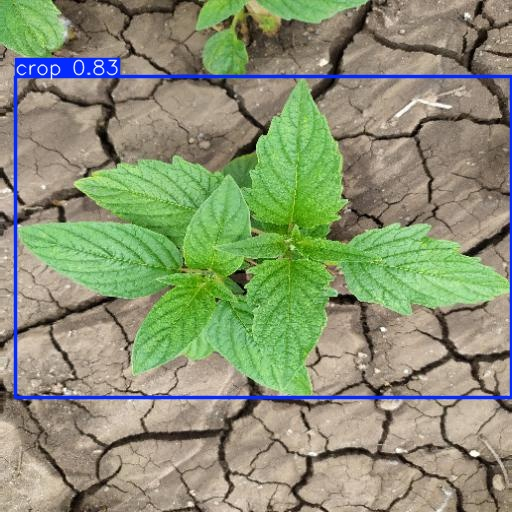


--- Step 5 Complete ---


In [13]:
from ultralytics import YOLO
import os
import random
from IPython.display import Image, display

print("\n--- Step 5: Making Predictions on a Sample Image ---")

# Define the path to the best trained model weights
run_dir = os.path.join(OUTPUT_DIR, 'yolo_runs', 'crop_weed_detection_v1_initial')
best_model_path = os.path.join(run_dir, 'weights', 'best.pt')
last_model_path = os.path.join(run_dir, 'weights', 'last.pt') # Path to the last saved model

# --- Load the model: Try best.pt first, then fallback to last.pt ---
model_to_load = None
if os.path.exists(best_model_path):
    model_to_load = best_model_path
    print(f"Loading best model from: {best_model_path}")
elif os.path.exists(last_model_path):
    model_to_load = last_model_path
    print(f"Best model not found. Loading last model from: {last_model_path}")
else:
    print(f"CRITICAL ERROR: Neither 'best.pt' nor 'last.pt' found in {os.path.join(run_dir, 'weights')}")
    print("Ensure the training run completed and saved models in the specified directory.")
    print(f"Contents of weights directory: {os.path.join(run_dir, 'weights')}")
    !ls -F "{os.path.join(run_dir, 'weights')}" # List contents to help debug


if model_to_load:
    model = YOLO(model_to_load)

    # --- Select a sample image for inference ---
    sample_image_for_inference_path = None
    if 'test_data' in globals() and len(test_data) > 0:
        sample_image_for_inference_path = test_data[random.randint(0, len(test_data) - 1)][0] # Pick a random image from test set
        print(f"Using a random test set image for inference: {sample_image_for_inference_path}")
    else:
        print("Test data not available or empty. Picking a random image from the entire dataset for inference.")
        all_files_in_data_folder = os.listdir(IMAGES_DIR)
        image_files = [f for f in all_files_in_data_folder if f.lower().endswith(('.jpeg', '.jpg', '.png'))]
        if image_files:
            sample_image_for_inference_path = os.path.join(IMAGES_DIR, random.choice(image_files))
        else:
            print("No image files found in the data directory. Cannot perform inference.")

    if sample_image_for_inference_path:
        # Define the base directory where prediction results will be saved on Drive for this improved run
        predict_results_base_dir = os.path.join(run_dir, 'predict_results_v2') # Save within the specific run's folder
        os.makedirs(predict_results_base_dir, exist_ok=True) # Ensure the directory exists

        results_list = model.predict(
            source=sample_image_for_inference_path,
            save=True,          # Save the image with detections
            imgsz=512,          # Image size for inference
            conf=0.25,          # Confidence threshold for detections (adjust if too many/few detections)
            project=predict_results_base_dir, # Tell YOLO to save directly to this Drive path
            name='predictions'      # Name the specific prediction run folder inside predict_results_base_dir
        )

        # Construct the path to the saved image (assuming .jpg output)
        actual_saved_predict_output_dir = os.path.join(predict_results_base_dir, 'predictions') # 'predictions' is from 'name' arg
        base_filename = os.path.splitext(os.path.basename(sample_image_for_inference_path))[0]
        predicted_image_path = os.path.join(actual_saved_predict_output_dir, base_filename + '.jpg')

        if os.path.exists(predicted_image_path):
            print(f"\nDisplaying predicted image with detections from: {predicted_image_path}")
            display(Image(filename=predicted_image_path, width=800))
        else:
            print(f"Predicted image not found at expected path: {predicted_image_path}")
            print("Confirm the output file extension or path in the 'predictions' subfolder on Google Drive.")
            print(f"Contents of '{actual_saved_predict_output_dir}':")
            !ls -F "{actual_saved_predict_output_dir}" # List contents to help debug
    else:
        print("Could not find a suitable image for inference.")

print("\n--- Step 5 Complete ---")

In [14]:
from ultralytics import YOLO
import os
from IPython.display import Image, display

print("\n--- Step 6: Running Predictions on the Entire Test Set ---")

# Define the path to the best trained model weights from the LATEST run
# Make sure 'crop_weed_detection_v1_initial' matches your training run name
current_run_dir = os.path.join(OUTPUT_DIR, 'yolo_runs', 'crop_weed_detection_v1_initial')
best_model_path = os.path.join(current_run_dir, 'weights', 'best.pt')
last_model_path = os.path.join(current_run_dir, 'weights', 'last.pt') # Path to the last saved model

# --- Load the model: Try best.pt first, then fallback to last.pt ---
model_to_load = None
if os.path.exists(best_model_path):
    model_to_load = best_model_path
    print(f"Loading best model from: {best_model_path}")
elif os.path.exists(last_model_path):
    model_to_load = last_model_path
    print(f"Best model not found. Loading last model from: {last_model_path}")
else:
    print(f"CRITICAL ERROR: Neither 'best.pt' nor 'last.pt' found in {os.path.join(current_run_dir, 'weights')}")
    print("Ensure the training run completed and saved models in the specified directory.")
    print(f"Contents of weights directory: {os.path.join(current_run_dir, 'weights')}")
    !ls -F "{os.path.join(current_run_dir, 'weights')}" # List contents to help debug


if model_to_load:
    model = YOLO(model_to_load)

    # Define the output directory for this test set prediction run on Drive
    test_prediction_output_dir = os.path.join(current_run_dir, 'test_set_predictions')
    os.makedirs(test_prediction_output_dir, exist_ok=True)
    print(f"Test set predictions will be saved to: {test_prediction_output_dir}")

    # Prepare a list of all image paths in the test set
    test_image_paths = [pair[0] for pair in test_data] if 'test_data' in globals() else []

    if test_image_paths:
        print(f"Running inference on {len(test_image_paths)} images from the test set...")

        # Run inference on the entire test set
        # The 'save=True' option will save each predicted image with its bounding boxes
        results = model.predict(
            source=test_image_paths,
            save=True,
            imgsz=512,
            conf=0.25,
            project=test_prediction_output_dir,
            name='test_set_results'
        )

        print("\nTest set predictions complete!")
        print(f"Results are saved on your Google Drive in: {os.path.join(test_prediction_output_dir, 'test_set_results')}")
    else:
        print("Test data list is empty or not defined. Cannot run full test set predictions.")
else:
    print("Cannot proceed with predictions as no model weights could be loaded.")


--- Step 6: Running Predictions on the Entire Test Set ---
Loading best model from: /content/drive/MyDrive/Colab_Projects/CropWeedDetection_Project/outputs/yolo_runs/crop_weed_detection_v1_initial/weights/best.pt
Test set predictions will be saved to: /content/drive/MyDrive/Colab_Projects/CropWeedDetection_Project/outputs/yolo_runs/crop_weed_detection_v1_initial/test_set_predictions
Running inference on 130 images from the test set...

0: 512x512 2 crops, 2.4ms
1: 512x512 2 weeds, 2.4ms
2: 512x512 2 crops, 2.4ms
3: 512x512 1 weed, 2.4ms
4: 512x512 2 weeds, 2.4ms
5: 512x512 1 weed, 2.4ms
6: 512x512 1 weed, 2.4ms
7: 512x512 1 weed, 2.4ms
8: 512x512 2 weeds, 2.4ms
9: 512x512 21 crops, 2.4ms
10: 512x512 1 crop, 2.4ms
11: 512x512 1 weed, 2.4ms
12: 512x512 1 weed, 2.4ms
13: 512x512 1 crop, 2.4ms
14: 512x512 1 crop, 2.4ms
15: 512x512 1 crop, 2.4ms
16: 512x512 6 crops, 2.4ms
17: 512x512 21 crops, 2.4ms
18: 512x512 1 weed, 2.4ms
19: 512x512 6 weeds, 2.4ms
20: 512x512 1 weed, 2.4ms
21: 512x512 

In [16]:
from ultralytics import YOLO
import os

print("\n--- Step 7: Evaluating Model Performance on Test Set ---")

# Define the path to the best trained model weights from the LATEST run
# Make sure 'crop_weed_detection_v1_initial' matches your training run name
current_run_dir = os.path.join(OUTPUT_DIR, 'yolo_runs', 'crop_weed_detection_v1_initial')
best_model_path = os.path.join(current_run_dir, 'weights', 'best.pt')
last_model_path = os.path.join(current_run_dir, 'weights', 'last.pt')

# --- Load the model: Try best.pt first, then fallback to last.pt ---
model_to_load = None
if os.path.exists(best_model_path):
    model_to_load = best_model_path
    print(f"Loading best model for validation from: {best_model_path}")
elif os.path.exists(last_model_path):
    model_to_load = last_model_path
    print(f"Best model not found. Loading last model for validation from: {last_model_path}")
else:
    print(f"CRITICAL ERROR: Neither 'best.pt' nor 'last.pt' found in {os.path.join(current_run_dir, 'weights')}")
    print("Ensure the training run completed and saved models.")
    model_to_load = None

if model_to_load:
    model = YOLO(model_to_load)

    # Define the path to your data.yaml
    data_yaml_path = os.path.join(PROJECT_DRIVE_PATH, 'data.yaml')

    # The 'val' method runs on the test set by default.
    # The 'split' argument caused the error because your data.yaml did not have a 'test' path.
    # We will remove it and let YOLO use the 'val' path from your data.yaml.
    print("Running validation on the val split defined in data.yaml...")
    metrics = model.val(
        data=data_yaml_path,
        imgsz=512,
        batch=16
    )

    print("\n--- Model Validation Complete ---")
    print("\nModel performance metrics:")
    print(f"  Precision: {metrics.box.mp:.4f}")
    print(f"  Recall: {metrics.box.mr:.4f}")
    print(f"  mAP50: {metrics.box.map50:.4f}")
    print(f"  mAP50-95: {metrics.box.map:.4f}")
else:
    print("Cannot proceed with validation as no model weights could be loaded.")


--- Step 7: Evaluating Model Performance on Test Set ---
Loading best model for validation from: /content/drive/MyDrive/Colab_Projects/CropWeedDetection_Project/outputs/yolo_runs/crop_weed_detection_v1_initial/weights/best.pt
Running validation on the val split defined in data.yaml...
Ultralytics 8.3.174 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.4±0.1 ms, read: 31.7±12.7 MB/s, size: 59.3 KB)


val: Scanning /content/drive/MyDrive/Colab_Projects/CropWeedDetection_Project/crop_weed_data.cache... 1300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1300/1300 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 82/82 [00:33<00:00,  2.42it/s]


                   all       1300       2072      0.821      0.846      0.888      0.603
                  crop        635       1212       0.77      0.839      0.878       0.62
                  weed        667        860      0.872      0.853      0.899      0.587
Speed: 0.7ms preprocess, 2.7ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs/detect/val2

--- Model Validation Complete ---

Model performance metrics:
  Precision: 0.8208
  Recall: 0.8463
  mAP50: 0.8884
  mAP50-95: 0.6034


In [17]:
from ultralytics import YOLO
import os

print("\n--- NEW Training Run: 50 Epochs ---")
print("This will train a fresh model for 50 epochs and save results to a new folder.")

# Load a pre-trained YOLOv8n model
model = YOLO('yolov8n.pt')

# Define the path to your data.yaml
data_yaml_path = os.path.join(PROJECT_DRIVE_PATH, 'data.yaml')

# Train the model with a new name to avoid conflicts
results = model.train(
    data=data_yaml_path,
    epochs=50, # Training for 50 epochs
    imgsz=512,
    project=os.path.join(OUTPUT_DIR, 'yolo_runs'),
    name='crop_weed_detection_v3_50_epochs', # A new, unique name for this training run
    device=0,
    save_period=5,
    batch=16
)

print("\n--- New training run initiated. Results will be saved to your Google Drive ---")
print(f"Check results in: {os.path.join(OUTPUT_DIR, 'yolo_runs', 'crop_weed_detection_v3_50_epochs')}")


--- NEW Training Run: 50 Epochs ---
This will train a fresh model for 50 epochs and save results to a new folder.
Ultralytics 8.3.174 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/Colab_Projects/CropWeedDetection_Project/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=512, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, n

train: Scanning /content/drive/MyDrive/Colab_Projects/CropWeedDetection_Project/crop_weed_data.cache... 1300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1300/1300 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 3.2±4.5 ms, read: 20.4±13.1 MB/s, size: 61.5 KB)


val: Scanning /content/drive/MyDrive/Colab_Projects/CropWeedDetection_Project/crop_weed_data.cache... 1300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1300/1300 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/Colab_Projects/CropWeedDetection_Project/outputs/yolo_runs/crop_weed_detection_v3_50_epochs/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 512 train, 512 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/Colab_Projects/CropWeedDetection_Project/outputs/yolo_runs/crop_weed_detection_v3_50_epochs
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      2.78G      1.426       2.19      1.619          6        512: 100%|██████████| 82/82 [00:20<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 41/41 [00:10<00:00,  3.82it/s]


                   all       1300       2072      0.649      0.508      0.591      0.314

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      2.78G      1.361      1.617       1.53          5        512: 100%|██████████| 82/82 [00:20<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 41/41 [00:10<00:00,  4.01it/s]


                   all       1300       2072      0.375      0.513      0.365      0.162

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      2.78G      1.396       1.55      1.541          9        512: 100%|██████████| 82/82 [00:19<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 41/41 [00:11<00:00,  3.67it/s]


                   all       1300       2072      0.255      0.276      0.175     0.0765

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      2.78G       1.42      1.451      1.555          8        512: 100%|██████████| 82/82 [00:18<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 41/41 [00:11<00:00,  3.62it/s]


                   all       1300       2072      0.662      0.634      0.672      0.341

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50       2.8G      1.409      1.368      1.542          6        512: 100%|██████████| 82/82 [00:19<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 41/41 [00:11<00:00,  3.71it/s]


                   all       1300       2072      0.752      0.579      0.679      0.361

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50       2.8G      1.366      1.303      1.521         15        512: 100%|██████████| 82/82 [00:20<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 41/41 [00:09<00:00,  4.16it/s]


                   all       1300       2072      0.781      0.644      0.751      0.433

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50       2.8G      1.341      1.253      1.493         11        512: 100%|██████████| 82/82 [00:20<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 41/41 [00:10<00:00,  3.94it/s]


                   all       1300       2072      0.704      0.659      0.738      0.428

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50       2.8G      1.307      1.188      1.476         13        512: 100%|██████████| 82/82 [00:18<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 41/41 [00:10<00:00,  3.80it/s]

                   all       1300       2072      0.766      0.729      0.788      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50       2.8G      1.275       1.18      1.449         18        512: 100%|██████████| 82/82 [00:19<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 41/41 [00:10<00:00,  3.76it/s]


                   all       1300       2072      0.724      0.683      0.747      0.458

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      2.82G      1.307      1.165       1.47         17        512: 100%|██████████| 82/82 [00:18<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 41/41 [00:11<00:00,  3.72it/s]


                   all       1300       2072      0.756      0.757      0.813      0.486

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      2.82G      1.276       1.16      1.445          8        512: 100%|██████████| 82/82 [00:20<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 41/41 [00:09<00:00,  4.24it/s]

                   all       1300       2072      0.802      0.728      0.818      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      2.82G      1.248      1.115      1.442         15        512: 100%|██████████| 82/82 [00:20<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 41/41 [00:10<00:00,  3.82it/s]

                   all       1300       2072      0.759      0.722      0.805      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      2.82G       1.26      1.095      1.437         10        512: 100%|██████████| 82/82 [00:18<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 41/41 [00:10<00:00,  3.78it/s]


                   all       1300       2072      0.778      0.772      0.815      0.518

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      2.82G       1.23      1.068      1.419          8        512: 100%|██████████| 82/82 [00:19<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 41/41 [00:10<00:00,  3.79it/s]


                   all       1300       2072      0.822      0.765      0.838       0.54

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      2.82G      1.231      1.053      1.413         10        512: 100%|██████████| 82/82 [00:19<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 41/41 [00:10<00:00,  3.83it/s]


                   all       1300       2072      0.796      0.735      0.803      0.508

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      2.83G      1.219      1.059      1.406         24        512: 100%|██████████| 82/82 [00:20<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 41/41 [00:09<00:00,  4.39it/s]


                   all       1300       2072      0.761      0.791      0.823      0.521

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      2.84G      1.224      1.035      1.406         21        512: 100%|██████████| 82/82 [00:20<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 41/41 [00:10<00:00,  4.08it/s]


                   all       1300       2072      0.798      0.782      0.825      0.514

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      2.85G      1.197      0.997      1.401         14        512: 100%|██████████| 82/82 [00:19<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 41/41 [00:10<00:00,  3.82it/s]


                   all       1300       2072      0.801      0.779      0.855      0.568

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      2.87G      1.174     0.9868      1.377          7        512: 100%|██████████| 82/82 [00:18<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 41/41 [00:10<00:00,  3.76it/s]


                   all       1300       2072      0.807      0.799      0.866      0.564

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      2.87G      1.174     0.9737       1.38          9        512: 100%|██████████| 82/82 [00:18<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 41/41 [00:11<00:00,  3.67it/s]


                   all       1300       2072      0.803      0.778      0.854      0.562

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      2.87G      1.183     0.9749      1.382         22        512: 100%|██████████| 82/82 [00:19<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 41/41 [00:10<00:00,  3.83it/s]


                   all       1300       2072      0.828      0.782      0.865      0.541

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      2.88G      1.188     0.9753      1.386         14        512: 100%|██████████| 82/82 [00:20<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 41/41 [00:09<00:00,  4.39it/s]


                   all       1300       2072      0.846      0.802      0.873      0.576

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      2.88G      1.167     0.9543      1.377         13        512: 100%|██████████| 82/82 [00:20<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 41/41 [00:10<00:00,  3.81it/s]

                   all       1300       2072       0.85      0.803      0.886       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      2.88G      1.171     0.9527      1.373         17        512: 100%|██████████| 82/82 [00:19<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 41/41 [00:10<00:00,  3.80it/s]

                   all       1300       2072      0.843      0.803      0.879      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      2.88G      1.151     0.9186      1.377         12        512: 100%|██████████| 82/82 [00:19<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 41/41 [00:11<00:00,  3.71it/s]

                   all       1300       2072      0.857      0.804      0.879      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      2.88G      1.159     0.9156      1.379          7        512: 100%|██████████| 82/82 [00:20<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 41/41 [00:10<00:00,  3.88it/s]


                   all       1300       2072      0.852       0.78      0.869      0.578

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      2.88G      1.134     0.8878      1.339         20        512: 100%|██████████| 82/82 [00:20<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 41/41 [00:09<00:00,  4.12it/s]

                   all       1300       2072      0.845       0.81      0.886      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      2.88G      1.142     0.8801       1.35         14        512: 100%|██████████| 82/82 [00:20<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 41/41 [00:10<00:00,  3.78it/s]


                   all       1300       2072      0.862      0.799      0.886       0.59

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      2.88G      1.099     0.8594      1.328         10        512: 100%|██████████| 82/82 [00:19<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 41/41 [00:10<00:00,  3.76it/s]


                   all       1300       2072      0.818      0.806      0.865      0.582

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      2.88G      1.114     0.8641       1.34         11        512: 100%|██████████| 82/82 [00:18<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 41/41 [00:11<00:00,  3.70it/s]


                   all       1300       2072      0.836      0.816      0.883      0.594

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      2.88G      1.104     0.8679      1.335         11        512: 100%|██████████| 82/82 [00:20<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 41/41 [00:09<00:00,  4.19it/s]


                   all       1300       2072      0.858      0.808      0.887      0.608

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      2.88G       1.13     0.8685      1.352         11        512: 100%|██████████| 82/82 [00:21<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 41/41 [00:10<00:00,  4.02it/s]


                   all       1300       2072      0.843       0.82      0.892      0.609

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      2.88G       1.12     0.8532      1.337         12        512: 100%|██████████| 82/82 [00:19<00:00,  4.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 41/41 [00:10<00:00,  3.76it/s]


                   all       1300       2072      0.853      0.826       0.89      0.612

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      2.88G      1.086     0.8597      1.324         12        512: 100%|██████████| 82/82 [00:19<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 41/41 [00:11<00:00,  3.67it/s]


                   all       1300       2072      0.842      0.805      0.885      0.609

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      2.88G      1.072     0.8684      1.325         31        512: 100%|██████████| 82/82 [00:18<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 41/41 [00:10<00:00,  3.74it/s]

                   all       1300       2072      0.844      0.823      0.888      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      2.88G      1.095     0.8229      1.316         26        512: 100%|██████████| 82/82 [00:19<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 41/41 [00:09<00:00,  4.25it/s]

                   all       1300       2072      0.857      0.827      0.898      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      2.88G      1.064     0.8151       1.31         17        512: 100%|██████████| 82/82 [00:20<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 41/41 [00:10<00:00,  3.83it/s]

                   all       1300       2072      0.824      0.843      0.893       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      2.88G      1.057     0.8268      1.302         16        512: 100%|██████████| 82/82 [00:19<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 41/41 [00:10<00:00,  3.75it/s]


                   all       1300       2072      0.856      0.846      0.905      0.627

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      2.88G      1.078     0.8406      1.309          9        512: 100%|██████████| 82/82 [00:19<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 41/41 [00:10<00:00,  3.76it/s]

                   all       1300       2072      0.865      0.825      0.902      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      2.88G      1.068     0.8309      1.299          9        512: 100%|██████████| 82/82 [00:19<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 41/41 [00:10<00:00,  3.76it/s]


                   all       1300       2072      0.842      0.852      0.903      0.629
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      2.88G     0.9768     0.7523       1.32         13        512: 100%|██████████| 82/82 [00:21<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 41/41 [00:09<00:00,  4.37it/s]


                   all       1300       2072      0.849       0.82      0.895      0.634

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      2.88G     0.9655     0.6851      1.291          5        512: 100%|██████████| 82/82 [00:19<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 41/41 [00:11<00:00,  3.72it/s]

                   all       1300       2072      0.842       0.85      0.905      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      2.88G     0.9625     0.6918      1.299          5        512: 100%|██████████| 82/82 [00:18<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 41/41 [00:11<00:00,  3.71it/s]

                   all       1300       2072      0.852      0.854      0.907       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      2.88G     0.9484     0.6723      1.293          5        512: 100%|██████████| 82/82 [00:18<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 41/41 [00:11<00:00,  3.66it/s]

                   all       1300       2072      0.864      0.858      0.915      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      2.88G     0.9358     0.6586      1.283          7        512: 100%|██████████| 82/82 [00:18<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 41/41 [00:10<00:00,  3.80it/s]


                   all       1300       2072      0.858      0.843      0.911      0.652

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      2.88G     0.9155      0.647      1.259          4        512: 100%|██████████| 82/82 [00:18<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 41/41 [00:10<00:00,  3.87it/s]


                   all       1300       2072      0.856      0.858      0.919      0.661

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      2.88G     0.9166     0.6335      1.254          8        512: 100%|██████████| 82/82 [00:20<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 41/41 [00:09<00:00,  4.33it/s]

                   all       1300       2072      0.865      0.851      0.917      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      2.88G     0.9042     0.6223      1.261          4        512: 100%|██████████| 82/82 [00:20<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 41/41 [00:10<00:00,  3.95it/s]

                   all       1300       2072      0.862      0.857      0.919      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      2.88G     0.9061      0.629      1.249          6        512: 100%|██████████| 82/82 [00:18<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 41/41 [00:10<00:00,  3.73it/s]


                   all       1300       2072      0.863      0.844      0.918      0.668

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      2.88G     0.9074     0.6339      1.254          6        512: 100%|██████████| 82/82 [00:18<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 41/41 [00:10<00:00,  3.74it/s]


                   all       1300       2072      0.876      0.841       0.92      0.668

50 epochs completed in 0.428 hours.
Optimizer stripped from /content/drive/MyDrive/Colab_Projects/CropWeedDetection_Project/outputs/yolo_runs/crop_weed_detection_v3_50_epochs/weights/last.pt, 6.2MB
Optimizer stripped from /content/drive/MyDrive/Colab_Projects/CropWeedDetection_Project/outputs/yolo_runs/crop_weed_detection_v3_50_epochs/weights/best.pt, 6.2MB

Validating /content/drive/MyDrive/Colab_Projects/CropWeedDetection_Project/outputs/yolo_runs/crop_weed_detection_v3_50_epochs/weights/best.pt...
Ultralytics 8.3.174 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 41/41 [00:12<00:00,  3.25it/s]


                   all       1300       2072      0.864      0.845      0.918      0.669
                  crop        635       1212      0.806      0.837        0.9      0.675
                  weed        667        860      0.922      0.853      0.936      0.663
Speed: 0.2ms preprocess, 1.9ms inference, 0.0ms loss, 2.5ms postprocess per image
Results saved to /content/drive/MyDrive/Colab_Projects/CropWeedDetection_Project/outputs/yolo_runs/crop_weed_detection_v3_50_epochs

--- New training run initiated. Results will be saved to your Google Drive ---
Check results in: /content/drive/MyDrive/Colab_Projects/CropWeedDetection_Project/outputs/yolo_runs/crop_weed_detection_v3_50_epochs


In [7]:
import matplotlib.pyplot as plt
import os
from IPython.display import Image, display

print("\n--- Step 2 (Project 5 - Continued): Displaying Improved Training Results ---")

# Navigate to the results directory of your LATEST training run
# This assumes your latest training run was named 'crop_weed_detection_v3_50_epochs'
current_run_dir = os.path.join(OUTPUT_DIR, 'yolo_runs', 'crop_weed_detection_v3_50_epochs')

if not os.path.exists(current_run_dir):
    print(f"Error: Run directory not found: {current_run_dir}")
    print("Training might not have completed, or you might need to adjust the 'name' in model.train() if it was different.")
    print("Please check your Google Drive manually for the 'yolo_runs' folder inside your outputs directory.")
    !ls -F "{os.path.join(OUTPUT_DIR, 'yolo_runs')}"
else:
    plots_to_display = [
        'results.png',
        'confusion_matrix.png',
        'F1_curve.png',
        'PR_curve.png',
        'train_batch0.jpg',
        'val_batch0_pred.jpg'
    ]

    for plot_name in plots_to_display:
        plot_path = os.path.join(current_run_dir, plot_name)
        if os.path.exists(plot_path):
            print(f"\nDisplaying: {plot_name}")
            display(Image(filename=plot_path, width=800))
        else:
            print(f"Plot not found: {plot_path}")

print("\n--- Step 2 (Project 5 - Continued) Complete ---")

Output hidden; open in https://colab.research.google.com to view.

In [11]:
from ultralytics import YOLO
import os
from IPython.display import Image, display
import random

print("\n--- Step 5: Making Predictions with Improved Model ---")

# Define the path to the best trained model weights from the LATEST run
# This assumes your latest training run was named 'crop_weed_detection_v3_50_epochs'
current_run_dir = os.path.join(OUTPUT_DIR, 'yolo_runs', 'crop_weed_detection_v3_50_epochs')
best_model_path = os.path.join(current_run_dir, 'weights', 'best.pt')
last_model_path = os.path.join(current_run_dir, 'weights', 'last.pt')

# --- Load the model: Try best.pt first, then fallback to last.pt ---
model_to_load = None
if os.path.exists(best_model_path):
    model_to_load = best_model_path
    print(f"Loading best model from: {best_model_path}")
elif os.path.exists(last_model_path):
    model_to_load = last_model_path
    print(f"Best model not found. Loading last model from: {last_model_path}")
else:
    print(f"CRITICAL ERROR: Neither 'best.pt' nor 'last.pt' found in {os.path.join(current_run_dir, 'weights')}")
    print("Ensure the longer training run completed and saved models.")
    model_to_load = None

if model_to_load:
    model = YOLO(model_to_load)

    # --- Select a sample image for inference ---
    sample_image_for_inference_path = None
    if 'test_data' in globals() and len(test_data) > 0:
        sample_image_for_inference_path = test_data[random.randint(0, len(test_data) - 1)][0]
        print(f"Using a random test set image for inference: {sample_image_for_inference_path}")
    else:
        print("Test data not available or empty. Picking a random image from the entire dataset for inference.")
        all_files_in_data_folder = os.listdir(IMAGES_DIR)
        image_files = [f for f in all_files_in_data_folder if f.lower().endswith(('.jpeg', '.jpg', '.png'))]
        if image_files:
            sample_image_for_inference_path = os.path.join(IMAGES_DIR, random.choice(image_files))
        else:
            print("No image files found in the data directory. Cannot perform inference.")

    if sample_image_for_inference_path:
        predict_results_base_dir = os.path.join(current_run_dir, 'predict_results_v2')
        os.makedirs(predict_results_base_dir, exist_ok=True)

        results_list = model.predict(
            source=sample_image_for_inference_path,
            save=True,
            imgsz=512,
            conf=0.25,
            project=predict_results_base_dir,
            name='predictions'
        )

        actual_saved_predict_output_dir = os.path.join(predict_results_base_dir, 'predictions')
        base_filename = os.path.splitext(os.path.basename(sample_image_for_inference_path))[0]
        predicted_image_path = os.path.join(actual_saved_predict_output_dir, base_filename + '.jpg')

        if os.path.exists(predicted_image_path):
            print(f"\nDisplaying predicted image with detections from: {predicted_image_path}")
            display(Image(filename=predicted_image_path, width=800))
        else:
            print(f"Predicted image not found at expected path: {predicted_image_path}")
            print("Confirm the output file extension or path in the 'predictions' subfolder on Google Drive.")
            print(f"Contents of '{actual_saved_predict_output_dir}':")
            !ls -F "{actual_saved_predict_output_dir}"
    else:
        print("Could not find a suitable image for inference.")

print("\n--- Step 5 Complete ---")


--- Step 5: Making Predictions with Improved Model ---
Loading best model from: /content/drive/MyDrive/Colab_Projects/CropWeedDetection_Project/outputs/yolo_runs/crop_weed_detection_v3_50_epochs/weights/best.pt
Test data not available or empty. Picking a random image from the entire dataset for inference.

image 1/1 /content/drive/MyDrive/Colab_Projects/CropWeedDetection_Project/crop_weed_data/agri_0_3669.jpeg: 512x512 2 crops, 6.8ms
Speed: 5.4ms preprocess, 6.8ms inference, 312.7ms postprocess per image at shape (1, 3, 512, 512)
Results saved to /content/drive/MyDrive/Colab_Projects/CropWeedDetection_Project/outputs/yolo_runs/crop_weed_detection_v3_50_epochs/predict_results_v2/predictions2
Predicted image not found at expected path: /content/drive/MyDrive/Colab_Projects/CropWeedDetection_Project/outputs/yolo_runs/crop_weed_detection_v3_50_epochs/predict_results_v2/predictions/agri_0_3669.jpg
Confirm the output file extension or path in the 'predictions' subfolder on Google Drive.
Con

In [12]:
from ultralytics import YOLO
import os
from IPython.display import Image, display

print("\n--- Step 6: Running Predictions on the Entire Test Set ---")

# Define the path to the best trained model weights from the LATEST run
# Make sure 'crop_weed_detection_v1_initial' matches your training run name
current_run_dir = os.path.join(OUTPUT_DIR, 'yolo_runs', 'crop_weed_detection_v1_initial')
best_model_path = os.path.join(current_run_dir, 'weights', 'best.pt')
last_model_path = os.path.join(current_run_dir, 'weights', 'last.pt')

# --- Load the model: Try best.pt first, then fallback to last.pt ---
model_to_load = None
if os.path.exists(best_model_path):
    model_to_load = best_model_path
    print(f"Loading best model for test set predictions from: {best_model_path}")
elif os.path.exists(last_model_path):
    model_to_load = last_model_path
    print(f"Best model not found. Loading last model for test set predictions from: {last_model_path}")
else:
    print(f"CRITICAL ERROR: Neither 'best.pt' nor 'last.pt' found in {os.path.join(current_run_dir, 'weights')}")
    print("Ensure the training run completed and saved models.")
    model_to_load = None

if model_to_load:
    model = YOLO(model_to_load)

    # Define the output directory for this test set prediction run on Drive
    test_prediction_output_dir = os.path.join(current_run_dir, 'test_set_predictions')
    os.makedirs(test_prediction_output_dir, exist_ok=True)
    print(f"Test set predictions will be saved to: {test_prediction_output_dir}")

    # Prepare a list of all image paths in the test set
    test_image_paths = [pair[0] for pair in test_data] if 'test_data' in globals() else []

    if test_image_paths:
        print(f"Running inference on {len(test_image_paths)} images from the test set...")

        # Run inference on the entire test set
        # The 'save=True' option will save each predicted image with its bounding boxes
        results = model.predict(
            source=test_image_paths,
            save=True,
            imgsz=512,
            conf=0.25,
            project=test_prediction_output_dir,
            name='test_set_results'
        )

        print("\nTest set predictions complete!")
        print(f"Results are saved on your Google Drive in: {os.path.join(test_prediction_output_dir, 'test_set_results')}")
    else:
        print("Test data list is empty or not defined. Cannot run full test set predictions.")
else:
    print("Cannot proceed with predictions as no model weights could be loaded.")


--- Step 6: Running Predictions on the Entire Test Set ---
Loading best model for test set predictions from: /content/drive/MyDrive/Colab_Projects/CropWeedDetection_Project/outputs/yolo_runs/crop_weed_detection_v1_initial/weights/best.pt
Test set predictions will be saved to: /content/drive/MyDrive/Colab_Projects/CropWeedDetection_Project/outputs/yolo_runs/crop_weed_detection_v1_initial/test_set_predictions
Test data list is empty or not defined. Cannot run full test set predictions.


In [13]:
from ultralytics import YOLO
import os

print("\n--- Step 7: Evaluating Model Performance on Test Set ---")

# Define the path to the best trained model weights from the LATEST run
# Make sure 'crop_weed_detection_v1_initial' matches your training run name
current_run_dir = os.path.join(OUTPUT_DIR, 'yolo_runs', 'crop_weed_detection_v1_initial')
best_model_path = os.path.join(current_run_dir, 'weights', 'best.pt')
last_model_path = os.path.join(current_run_dir, 'weights', 'last.pt')

# --- Load the model: Try best.pt first, then fallback to last.pt ---
model_to_load = None
if os.path.exists(best_model_path):
    model_to_load = best_model_path
    print(f"Loading best model for validation from: {best_model_path}")
elif os.path.exists(last_model_path):
    model_to_load = last_model_path
    print(f"Best model not found. Loading last model for validation from: {last_model_path}")
else:
    print(f"CRITICAL ERROR: Neither 'best.pt' nor 'last.pt' found in {os.path.join(current_run_dir, 'weights')}")
    print("Ensure the training run completed and saved models.")
    model_to_load = None

if model_to_load:
    model = YOLO(model_to_load)

    # Define the path to your data.yaml
    data_yaml_path = os.path.join(PROJECT_DRIVE_PATH, 'data.yaml')

    # The 'val' method runs on the test set by default.
    # The 'split' argument caused the error because your data.yaml did not have a 'test' path.
    # We will remove it and let YOLO use the 'val' path from your data.yaml.
    print("Running validation on the val split defined in data.yaml...")
    metrics = model.val(
        data=data_yaml_path,
        imgsz=512,
        batch=16
    )

    print("\n--- Model Validation Complete ---")
    print("\nModel performance metrics:")
    print(f"  Precision: {metrics.box.mp:.4f}")
    print(f"  Recall: {metrics.box.mr:.4f}")
    print(f"  mAP50: {metrics.box.map50:.4f}")
    print(f"  mAP50-95: {metrics.box.map:.4f}")
else:
    print("Cannot proceed with validation as no model weights could be loaded.")


--- Step 7: Evaluating Model Performance on Test Set ---
Loading best model for validation from: /content/drive/MyDrive/Colab_Projects/CropWeedDetection_Project/outputs/yolo_runs/crop_weed_detection_v1_initial/weights/best.pt
Running validation on the val split defined in data.yaml...
Ultralytics 8.3.175 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


val: Fast image access ✅ (ping: 0.4±0.1 ms, read: 0.1±0.0 MB/s, size: 64.8 KB)


val: Scanning /content/drive/MyDrive/Colab_Projects/CropWeedDetection_Project/crop_weed_data.cache... 1300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1300/1300 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 82/82 [01:03<00:00,  1.30it/s]


                   all       1300       2072      0.821      0.846      0.888      0.603
                  crop        635       1212       0.77      0.839      0.878       0.62
                  weed        667        860      0.872      0.853      0.899      0.587
Speed: 0.8ms preprocess, 2.8ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs/detect/val

--- Model Validation Complete ---

Model performance metrics:
  Precision: 0.8208
  Recall: 0.8463
  mAP50: 0.8884
  mAP50-95: 0.6034
